## 데이터 가공

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
eq_df = pd.read_csv('kor_earthquake_new.csv')

In [4]:
# # 북한데이터 제거
# index_buk = eq_df[eq_df['Pos'].str.split(' ').str[0] == '북한'].index
# eq_no_buk = eq_df.drop(index_buk)
# eq_no_buk.reset_index(drop=True,inplace=True)
# eq_df = eq_no_buk

In [5]:
# # 진도 3 이상
# index_3 = eq_df[eq_df['Magnitude'] < 3.0].index
# eq_more_3 = eq_df.drop(index_3)
# eq_more_3.reset_index(drop=True, inplace=True)
# eq_df = eq_more_3

In [6]:
# 북한데이터 제거, 진도 3 이상
index_buk = eq_df[eq_df['Pos'].str.split(' ').str[0] == '북한'].index
eq_no_buk = eq_df.drop(index_buk)
index_3 = eq_no_buk[eq_no_buk['Magnitude'] < 3.0].index
eq_no_buk_and_more_3 = eq_no_buk.drop(index_3)
eq_no_buk_and_more_3.reset_index(drop=True, inplace=True)
eq_df = eq_no_buk_and_more_3

In [7]:
del eq_df['No']
del eq_df['Pos']
del eq_df['Date']

In [8]:
eq_df

,Magnitude,Latitude,Longitude
0,5.2,36.60,127.90
1,5.0,36.60,126.70
2,3.3,35.90,126.30
3,3.0,35.70,126.00
4,3.0,36.10,128.30
...,...,...,...
295,3.7,37.37,124.23
296,4.1,36.16,129.90
297,4.3,37.88,129.54
298,3.8,36.86,129.80


## 선형 회귀

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [10]:
y_target = eq_df['Magnitude']
X_features = eq_df.drop(['Magnitude'], axis=1, inplace=False)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state = 0)

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [13]:
y_preds = lr.predict(X_test)

In [14]:
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

In [15]:
print('MSE : {0:.3f}, RMSE : {1:.3F}'.format(mse, rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 0.252, RMSE : 0.502
Variance score : -0.017


In [16]:
print('절편 값 : ', lr.intercept_)
print('회귀 계수값 : ', np.round(lr.coef_,1))

절편 값 :  3.7436600185379745
회귀 계수값 :  [ 0. -0.]


In [17]:
coeff = pd.Series(data=np.round(lr.coef_,1), index=X_features.columns)
coeff.sort_values(ascending=False)

Longitude   -0.0
Latitude     0.0
dtype: float64

In [18]:
from sklearn.model_selection import cross_val_score

neg_mse_scores = cross_val_score(lr, X_features, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 folds 의 개별 Negative MSE scores : ', np.round(neg_mse_scores, 2))
print('5 folds 의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print('5 folds 의 평균 RMSE : {0:.3f}'.format(avg_rmse))

5 folds 의 개별 Negative MSE scores :  [-0.24 -0.26 -0.28 -0.23 -0.4 ]
5 folds 의 개별 RMSE scores :  [0.49 0.51 0.53 0.48 0.63]
5 folds 의 평균 RMSE : 0.528


## 릿지 회귀

In [19]:
from sklearn.linear_model import Ridge

# 릿지에 사용될 alpha 파라미터 값 정의
alphas = [0.1, 1, 10, 100]

# alphas list 값을 반복하면서 alpha에 따른 평균 RMSE를 구함
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    
    neg_mse_scores = cross_val_score(ridge, X_features, y_target, scoring='neg_mean_squared_error', cv=5)
    avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
    print("alpha {0}일 때 5 folds의 평균 RMSE : {1:.2f}".format(alpha, avg_rmse))

alpha 0.1일 때 5 folds의 평균 RMSE : 0.53
alpha 1일 때 5 folds의 평균 RMSE : 0.53
alpha 10일 때 5 folds의 평균 RMSE : 0.53
alpha 100일 때 5 folds의 평균 RMSE : 0.53


In [20]:
# alpha=10으로 설정해 릿지 회귀 수행
ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(ridge, X_features, y_target, scoring='neg_mean_squared_error', cv=5)
mse_scores = -1*neg_mse_scores
rmse_scores = np.sqrt(mse_scores)
avg_rmse = np.mean(rmse_scores)

print("5 folds의 개별 negative MSE scores : ", np.round(neg_mse_scores, 2))
print("5 folds의 개별 RMSE scores : ", np.round(rmse_scores, 2))
print("5 folds의 평균 RMSE : ", np.round(avg_rmse, 2))

5 folds의 개별 negative MSE scores :  [-0.24 -0.26 -0.28 -0.23 -0.4 ]
5 folds의 개별 RMSE scores :  [0.49 0.51 0.53 0.48 0.63]
5 folds의 평균 RMSE :  0.53


## 라쏘 회귀

In [21]:
from sklearn.linear_model import Lasso

# 라쏘에 사용될 alpha 파라미터 값 정의
alphas = [0.1, 1, 10, 100]

# alphas list 값을 반복하면서 alpha에 따른 평균 RMSE를 구함
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    
    neg_mse_scores = cross_val_score(lasso, X_features, y_target, scoring='neg_mean_squared_error', cv=5)
    avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
    print("alpha {0}일 때 5 folds의 평균 RMSE : {1:.2f}".format(alpha, avg_rmse))

alpha 0.1일 때 5 folds의 평균 RMSE : 0.52
alpha 1일 때 5 folds의 평균 RMSE : 0.52
alpha 10일 때 5 folds의 평균 RMSE : 0.52
alpha 100일 때 5 folds의 평균 RMSE : 0.52


In [22]:
# alpha=으로 설정해 라쏘 회귀 수행
lasso = Lasso(alpha=0)
neg_mse_scores = cross_val_score(lasso, X_features, y_target, scoring='neg_mean_squared_error', cv=5)
mse_scores = -1*neg_mse_scores
rmse_scores = np.sqrt(mse_scores)
avg_rmse = np.mean(rmse_scores)

print("5 folds의 개별 negative MSE scores : ", np.round(neg_mse_scores, 2))
print("5 folds의 개별 RMSE scores : ", np.round(rmse_scores, 2))
print("5 folds의 평균 RMSE : ", np.round(avg_rmse, 2))

5 folds의 개별 negative MSE scores :  [-0.24 -0.26 -0.28 -0.23 -0.4 ]
5 folds의 개별 RMSE scores :  [0.49 0.51 0.53 0.48 0.63]
5 folds의 평균 RMSE :  0.53


In [23]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha 값에 따른 회귀 모델의 평균 RMSE 출력, 회귀 계수 DataFrame으로 반환
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True):
    coeff_df = pd.DataFrame()
    if verbose:
        print("=====", model_name, "=====")
    for param in params:
        if model_name == 'Ridge':
            model = Ridge(alpha=param)
        elif model_name == 'Lasso':
            model = Lasso(alpha=param)
        elif model_name == 'ElasticNet':
            model = ElasticNet(alpha=param, l1_ratio=0.7)   
        neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring='neg_mean_squared_error', cv=5)
        avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
        print("alpha {0}일 때 5 folds의 평균 RMSE : {1:.2f}".format(param, avg_rmse))
        # 회귀 계수 추출
        model.fit(X_features, y_target)
        # 회귀 계수 Series로 변환, 이를 DataFrame의 칼럼으로 추가
        coeff = pd.Series(data=model.coef_, index=X_features.columns)
        colname = 'alpha : ' + str(param)
        coeff_df[colname] = coeff
    return coeff_df

# 선형 회귀 모델을 위한 데이터 변환

In [24]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# method : 표준 정규분포 변환, 최댓값/최솟값 정규화, 로그 변환 결정
# p_degree : 다항식 특성을 추가할 때 적용
def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data
        
    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(scaled_data)
        
    return scaled_data

In [25]:
# alpha 값을 다르게 적용
alphas = [0.1, 1, 10, 100]
# 원본 + 5개 방식으로 데이터 변환
scale_methods = [(None, None), ('Standard', None), ('Standard', 2), ('MinMax', None), ('MinMax', 2), \
                 ('Log', None), ('Log', 2)]

for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1], input_data=X_features)
    print("변환 유형 : {0}, Polynomial Degree : {1}".format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled, y_target_n=y_target, verbose=False)
    print("--------------------------------------------------")

변환 유형 : None, Polynomial Degree : None
alpha 0.1일 때 5 folds의 평균 RMSE : 0.53
alpha 1일 때 5 folds의 평균 RMSE : 0.53
alpha 10일 때 5 folds의 평균 RMSE : 0.53
alpha 100일 때 5 folds의 평균 RMSE : 0.53
--------------------------------------------------
변환 유형 : Standard, Polynomial Degree : None
alpha 0.1일 때 5 folds의 평균 RMSE : 0.53
alpha 1일 때 5 folds의 평균 RMSE : 0.53
alpha 10일 때 5 folds의 평균 RMSE : 0.53
alpha 100일 때 5 folds의 평균 RMSE : 0.53
--------------------------------------------------
변환 유형 : Standard, Polynomial Degree : 2
alpha 0.1일 때 5 folds의 평균 RMSE : 0.51
alpha 1일 때 5 folds의 평균 RMSE : 0.51
alpha 10일 때 5 folds의 평균 RMSE : 0.51
alpha 100일 때 5 folds의 평균 RMSE : 0.51
--------------------------------------------------
변환 유형 : MinMax, Polynomial Degree : None
alpha 0.1일 때 5 folds의 평균 RMSE : 0.53
alpha 1일 때 5 folds의 평균 RMSE : 0.53
alpha 10일 때 5 folds의 평균 RMSE : 0.53
alpha 100일 때 5 folds의 평균 RMSE : 0.52
--------------------------------------------------
변환 유형 : MinMax, Polynomial Degree : 2
alpha 0.1일 때 5 

## SVM(Support Vector Machine)

In [26]:
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

In [27]:
y_target = eq_df['Magnitude']
X_features = eq_df.drop(['Magnitude'], axis=1, inplace=False)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state = 0)

In [29]:
# clf = svm.SVC()
# clf.fit(X_train, y_trainc.astype(int))
# pred = clf.predict(X_test)

In [30]:
# accuracy = metrics.accuracy_score(y_test.round().astype(int), pred.round().astype(int))
# report = metrics.classification_report(y_test, pred)
# print("정확도 ", accuracy)
# print("리포트 \n", report)

## 로지스틱 회귀

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [32]:
# 데이터 분포 변환
scaler = StandardScaler()
X_features_scaled = scaler.fit_transform(X_features)

X_train, X_test, y_train, y_test = train_test_split(X_features_scaled, y_target, test_size=0.2, random_state=0)

In [33]:
# from sklearn.metrics import accuracy_score, roc_auc_score

# # 로지스틱 회귀를 이용해 학습 및 예측 수행
# lr_clf = LogisticRegression()
# lr_clf.fit(X_train, y_train.round().astype(int))
# lr_pred = lr_clf.predict(X_test).round().astype(int)

# # 정확도, roc_auc 측정
# print("정확도 : ", accuracy_score(y_test, lr_pred))
# print("roc_auc : ", roc_auc_score(y_test, lr_pred))

## 회귀 트리

In [34]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

rf = RandomForestRegressor(n_estimators=1000, random_state=0)
neg_mse_scores = cross_val_score(lasso, X_features, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print("5 folds의 개별 negative MSE scores : ", np.round(neg_mse_scores, 2))
print("5 folds의 개별 RMSE scores : ", np.round(rmse_scores, 2))
print("5 folds의 평균 RMSE : ", np.round(avg_rmse, 2))

5 folds의 개별 negative MSE scores :  [-0.24 -0.26 -0.28 -0.23 -0.4 ]
5 folds의 개별 RMSE scores :  [0.49 0.51 0.53 0.48 0.63]
5 folds의 평균 RMSE :  0.53


In [36]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# 선형 회귀와 결정 트리 기반의 Regressor 생성
lr_reg = LinearRegression()
dt_reg2 = DecisionTreeRegressor(max_depth=2)
dt_reg7 = DecisionTreeRegressor(max_depth=7)

In [48]:
# X_feature_lati = eq_df['Latitude'].values.reshape(-1, 1)
# X_feature_longi = eq_df['Longitude'].values.reshape(-1, 1)
# y_target = eq_df['Magnitude'].values.reshape(-1, 1)

lr_reg.fit(X_features, y_target)
dt_reg2.fit(X_features, y_target)
dt_reg7.fit(X_features, y_target)

pred_lr = lr_reg.predict(X_test)
pred_dt2 = dt_reg2.predict(X_test)
pred_dt7 = dt_reg7.predict(X_test)

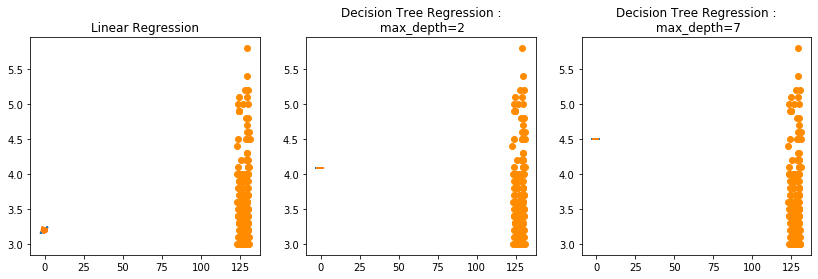

In [78]:
# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 4), ncols=3)

# # 시각화
# ax1.set_title('Linear Regression')
# ax1.scatter(X_features['Longitude'], y_target, c='darkorange')
# ax1.plot(X_test, pred_lr, label='linear', linewidth=2)
# ax2.set_title('Decision Tree Regression :\n max_depth=2')
# ax2.scatter(X_features['Longitude'], y_target, c='darkorange')
# ax2.plot(X_test, pred_dt2, label='max_depth=2', linewidth=2)
# ax3.set_title('Decision Tree Regression :\n max_depth=7')
# ax3.scatter(X_features['Longitude'], y_target, c='darkorange')
# ax3.plot(X_test, pred_dt7, label='max_depth=7', linewidth=2)

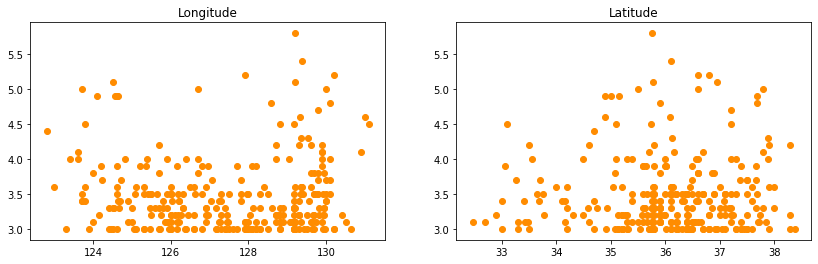

In [80]:
fig, (ax1, ax2) = plt.subplots(figsize=(14, 4), ncols=2)

# lati_start = 30
# lati_end = 40
# longi_start = 125
# longi_end = 135

# 시각화
ax1.set_title('Longitude')
ax1.scatter(X_features['Longitude'], y_target, c='darkorange')
# ax1.plot(X_test, pred_lr, label='linear', linewidth=2)
ax2.set_title('Latitude')
ax2.scatter(X_features['Latitude'], y_target, c='darkorange')
# ax2.plot(X_test, pred_dt2, label='max_depth=2', linewidth=2)